In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

from gensim.parsing.preprocessing import remove_stopwords, strip_multiple_whitespaces, strip_non_alphanum, strip_punctuation
from gensim.models.phrases import Phrases, Phraser

from fuzzywuzzy import process

from tqdm import tqdm_notebook

from IPython.display import HTML

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
%matplotlib inline

In [3]:
df = pd.read_csv(f"{os.getcwd()}/data/old/processed/concat_data.csv",
                    index_col=0)

In [4]:
df.head()

,conf,label,value,year,unit,file_name
0,96.0,notes,2017,2017.0,£,05457103_2018-08-10
1,96.0,notes,2016,2016.0,£,05457103_2018-08-10
2,96.0,tangible assets,405125,2017.0,£,05457103_2018-08-10
3,44.0,tangible assets,873945,2016.0,£,05457103_2018-08-10
4,95.0,debtors,875,2017.0,£,05457103_2018-08-10


Get number of times each unique value is read from a file

In [5]:
labels_df = pd.DataFrame(df.groupby("label").file_name.unique())

In [6]:
labels_df["number_of_files"] = [files.size for files in labels_df.file_name]

In [7]:
labels_df["ratio_of_files"] = labels_df.number_of_files.div(df.file_name.unique().size)

plot the top 25 occuring values

In [8]:
labels_df.shape

(743, 3)

In [9]:
labels_df[labels_df.number_of_files<6].shape

(660, 3)

In [10]:
labels_df[labels_df.number_of_files==1].shape

(558, 3)

In [11]:
labels_df.drop(["file_name"], axis=1).sort_values("ratio_of_files", ascending=False).iloc[:25]

,number_of_files,ratio_of_files
label,,
creditors amounts falling due within one year,238,0.470356
called up share capital,229,0.452569
net assets,216,0.426877
debtors,211,0.416996
net current assets,207,0.409091
total assets less current liabilities,202,0.399209
cash at bank and in hand,188,0.371542
tangible assets,160,0.316206
profit and loss account,128,0.252964


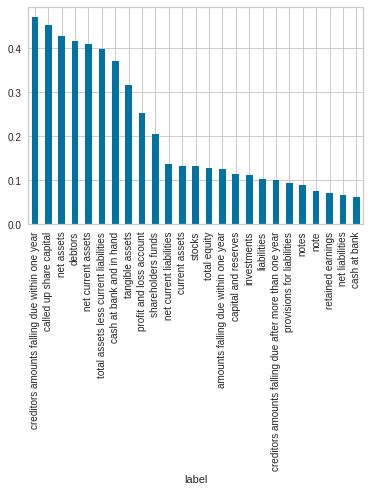

In [12]:
top_25_plot = labels_df.sort_values("ratio_of_files", ascending=False).iloc[:25].ratio_of_files.plot(kind="bar").get_figure()

In [13]:
top_25_plot.savefig(f"{os.getcwd()}/data/old/processed/top_25_variables.png",
                   bbox_inches = "tight")

this isn't great, it might be the case that some that are similar.

Lets split those that occour in < 1% (6) of all pdfs and see if we can use fuzzy matching to find something close.


In [14]:
rare_labels_df = labels_df[labels_df.number_of_files<6]

In [15]:
common_labels_df = labels_df[labels_df.number_of_files>5]

In [16]:
common_labels_lst = common_labels_df.index.to_list()
rare_labels_lst = rare_labels_df.index.to_list()

find the closest match using process in the fuzzywuzzy library

In [17]:
closest_match = [process.extractOne(rare_label, common_labels_lst) 
                 for rare_label in tqdm_notebook(rare_labels_lst)]

pull these out and put them in our rare_labels_df

In [18]:
rare_labels_df["closest_common_label"] = [match for match, score in closest_match]
rare_labels_df["closest_label_score"] = [score for match, score in closest_match]

/home/edd/.local/share/virtualenvs/explore-1I3eoxiK/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/edd/.local/share/virtualenvs/explore-1I3eoxiK/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Lets eyeball the data

In [19]:
HTML(rare_labels_df[["closest_common_label",
                     "closest_label_score"
                    ]].to_html())

,closest_common_label,closest_label_score
label,,
creditors amounts falling due after more than one year,creditors amounts falling due after more than ...,100
i,accruals and deferred income,60
.,accruals and deferred income,0
. . year,retained earnings,68
. creditors amounts falling due within on year,creditors amounts falling due within one year,99
. derivative assets exchange rate contracts crosscurrency swaps,current assets,86
. derivative assets exchange rate contracts securitisation cross currency swaps,current assets,86
. derivative assets interest rate contracts bermudan swaptions,current assets,86
. derivative liabilities interest rate contracts bermudan swaptions q,liabilities,90


From this we can be pretty sure that anything with a match score of greater than 90 is going to be a good match. So we can replace the name of the variable with the more commonly occuring one.

In [20]:
label_matches_tup = zip(rare_labels_df.index.to_list(), 
                        rare_labels_df.closest_common_label.to_list(),
                        rare_labels_df.closest_label_score.to_list()
                       )

rare_labels_df["new_labels"] = [best_match if score > 90 else current 
                                for current, best_match, score in label_matches_tup]
    

/home/edd/.local/share/virtualenvs/explore-1I3eoxiK/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [21]:
new_rare_labels_df = rare_labels_df.reset_index().rename(columns={"label": "old_labels",
                                             "new_labels" : "label"
                                            })



now groupby and sum the file count again, as it is likely some have been assigned the same new variable

In [22]:
new_rare_label_counts_df = pd.DataFrame(new_rare_labels_df.groupby("label").number_of_files.sum())

In [23]:
new_rare_label_counts_df.sort_values("number_of_files", ascending=False)

,number_of_files
label,
creditors amounts falling due within one year,36
total assets less current liabilities,19
called up share capital,17
creditors amounts falling due after more than one year,14
shareholders funds,12
profit and loss account,11
retained earnings,9
amounts falling due after more than one year,8
net current assets,8


now merge with the common labels, and sum the file counts to get the new file counts and ratios

In [24]:
common_labels_df = common_labels_df.merge(new_rare_label_counts_df, 
                                          left_index=True, 
                                          right_index=True,
                                          suffixes=["","_rare"]
                                         )

In [25]:
common_labels_df["number_of_files_new"] = common_labels_df.number_of_files.add(common_labels_df.number_of_files_rare)

In [26]:
common_labels_df["ratio_of_files_new"] = common_labels_df["number_of_files_new"].div(df.file_name.unique().size)

In [27]:
common_labels_df[["number_of_files", 
                  "number_of_files_new",
                  "ratio_of_files",
                  "ratio_of_files_new"]].sort_values("ratio_of_files_new",
                                                    ascending=False)

,number_of_files,number_of_files_new,ratio_of_files,ratio_of_files_new
label,,,,
creditors amounts falling due within one year,238,274,0.470356,0.541502
called up share capital,229,246,0.452569,0.486166
total assets less current liabilities,202,221,0.399209,0.436759
net assets,216,220,0.426877,0.434783
net current assets,207,215,0.409091,0.424901
debtors,211,215,0.416996,0.424901
cash at bank and in hand,188,195,0.371542,0.385375
tangible assets,160,167,0.316206,0.330040
profit and loss account,128,139,0.252964,0.274704


looks like some progress... up over 50% on one!

I mean, not huge, but progress,

a graph

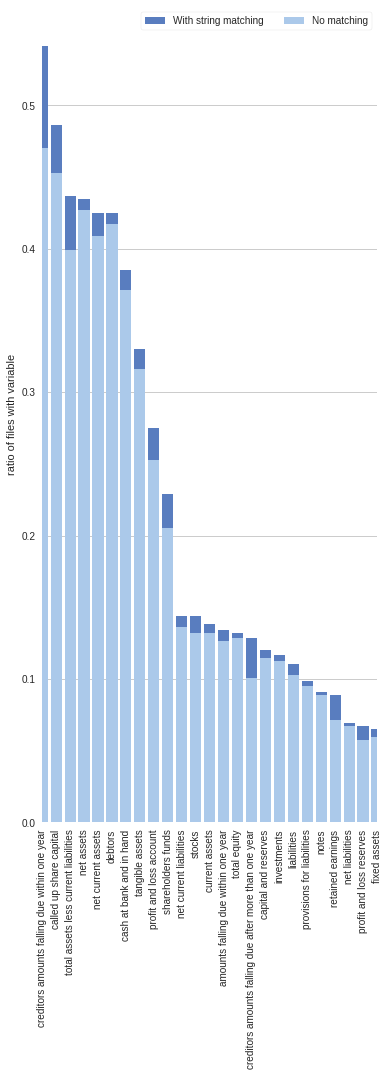

In [28]:
f, ax = plt.subplots(figsize=(6, 15))

sns.set_color_codes("muted")
sns.barplot(x="label", 
            y="ratio_of_files_new", 
            data=common_labels_df.sort_values("ratio_of_files_new",
                                              ascending=False
                                             ).iloc[:25].reset_index(),
            label="With string matching", 
            color="b")


sns.set_color_codes("pastel")
sns.barplot(x="label", 
            y="ratio_of_files", 
            data=common_labels_df.sort_values("ratio_of_files_new",
                                              ascending=False
                                             ).iloc[:25].reset_index(),
            label="No matching", 
            color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(0, 24), xlabel="",
       ylabel="ratio of files with variable")
ax.set_xticklabels(rotation=90, labels = common_labels_df.sort_values("ratio_of_files_new",
                                              ascending=False
                                             ).iloc[:25].index.to_list())
sns.despine(left=True, bottom=True)

In [29]:
f.savefig(f"{os.getcwd()}/data/old/processed/top_25_variables_matching.png",
                   bbox_inches = "tight")

alright then, lets save the data for ... reasons ....

In [30]:
common_labels_df.to_csv(f"{os.getcwd()}/data/old/processed/matched_common_labels.csv")

In [31]:
new_labels_df = pd.concat([common_labels_df, rare_labels_df])

/home/edd/.local/share/virtualenvs/explore-1I3eoxiK/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [32]:
new_labels_df

,closest_common_label,closest_label_score,file_name,new_labels,number_of_files,number_of_files_new,number_of_files_rare,ratio_of_files,ratio_of_files_new
label,,,,,,,,,
accruals and deferred income,NaN,NaN,"[07314921_2018-06-21, 05305200_2018-11-27, 025...",NaN,31,32.0,1.0,0.061265,0.063241
amounts falling due after more than one year,NaN,NaN,"[05549284_2018-04-05, 01246756_2018-12-28, 085...",NaN,12,20.0,8.0,0.023715,0.039526
amounts falling due within one year,NaN,NaN,"[02723119_2018-07-10, 07987664_2018-11-22, 055...",NaN,64,68.0,4.0,0.126482,0.134387
called up share capital,NaN,NaN,"[04578942_2018-09-10, 10339765_2018-05-21, 075...",NaN,229,246.0,17.0,0.452569,0.486166
capital and reserves,NaN,NaN,"[09946357_2018-10-11, 04210567_2018-06-13, 065...",NaN,58,61.0,3.0,0.114625,0.120553
capital redemption reserve,NaN,NaN,"[02736280_2018-01-18, 01581154_2018-07-24, 025...",NaN,9,10.0,1.0,0.017787,0.019763
cash and cash equivalents,NaN,NaN,"[00851110_2018-10-07, 07427985_2018-08-22, OC3...",NaN,8,13.0,5.0,0.015810,0.025692
cash at bank,NaN,NaN,"[08804092_2018-08-15, 01557781_2019-01-24, 089...",NaN,31,33.0,2.0,0.061265,0.065217
cash at bank and in hand,NaN,NaN,"[06757157_2018-08-15, 04578942_2018-09-10, NC0...",NaN,188,195.0,7.0,0.371542,0.385375


In [33]:
processed_labels = [remove_stopwords(label) for label in labels_df.index.to_list()]

In [34]:
processed_labels = [strip_non_alphanum(label) for label in processed_labels]

In [35]:
processed_labels = [strip_punctuation(label) for label in processed_labels]

In [36]:
processed_labels = [strip_multiple_whitespaces(label) for label in processed_labels]

In [37]:
processed_labels

['creditors amounts falling year',
 '',
 ' ',
 ' year',
 ' creditors amounts falling year',
 ' derivative assets exchange rate contracts crosscurrency swaps',
 ' derivative assets exchange rate contracts securitisation cross currency swaps',
 ' derivative assets rate contracts bermudan swaptions',
 ' derivative liabilities rate contracts bermudan swaptions q',
 ' donations legacies unrestricted restricted total total funds funds',
 ' fvtpl loans advances customers rollup mortgage portfolio',
 ' income charitable unrestricted restricted total total activities funds funds',
 ' mr l reed',
 ' notes consolidated financial statements year ended march',
 ' profit loss account',
 ' total long term liabilities',
 ' called equity share capital',
 ' note funds funds',
 '157301 783096 679940 total expenditure 620795 investments',
 '629100 594923 47671 89994 trading activities shop income 629100 income 47671 income investments gift aid receivable subsidiaries',
 '',
 'abbeyfield properties limited

In [38]:
labels_df["clean_labels"] = processed_labels

In [39]:
labels_df.clean_labels.to_list()

['creditors amounts falling year',
 '',
 ' ',
 ' year',
 ' creditors amounts falling year',
 ' derivative assets exchange rate contracts crosscurrency swaps',
 ' derivative assets exchange rate contracts securitisation cross currency swaps',
 ' derivative assets rate contracts bermudan swaptions',
 ' derivative liabilities rate contracts bermudan swaptions q',
 ' donations legacies unrestricted restricted total total funds funds',
 ' fvtpl loans advances customers rollup mortgage portfolio',
 ' income charitable unrestricted restricted total total activities funds funds',
 ' mr l reed',
 ' notes consolidated financial statements year ended march',
 ' profit loss account',
 ' total long term liabilities',
 ' called equity share capital',
 ' note funds funds',
 '157301 783096 679940 total expenditure 620795 investments',
 '629100 594923 47671 89994 trading activities shop income 629100 income 47671 income investments gift aid receivable subsidiaries',
 '',
 'abbeyfield properties limited

In [40]:
phrases = Phrases([sent.split(" ") for sent in labels_df.clean_labels.to_list()], 
                  min_count=2, 
                  threshold=1)

bigram_maker = Phraser(phrases)

In [41]:
bigram_lst = [sent 
           for sent in bigram_maker[[sent.split(" ") for sent in labels_df.clean_labels.to_list()]]]

In [42]:
bigrams = [" ".join(list(it.chain(bigrams))) 
           for bigrams in bigram_lst]

In [46]:
labels_df["bigram_labels"] = bigrams

In [47]:
labels_df

,file_name,number_of_files,ratio_of_files,clean_labels,bigram_labels
label,,,,,
creditors amounts falling due after more than one year,[01346397_2018-12-14],1,0.001976,creditors amounts falling year,creditors_amounts falling_year
i,[05476131_2018-07-10],1,0.001976,,
.,"[07025669_2018-01-09, 09469412_2019-01-05]",2,0.003953,,
. . year,[07444976_2018-12-27],1,0.001976,year,year
. creditors amounts falling due within on year,[10129537_2018-07-12],1,0.001976,creditors amounts falling year,creditors_amounts falling_year
. derivative assets exchange rate contracts crosscurrency swaps,[02338548_2018-03-23],1,0.001976,derivative assets exchange rate contracts cro...,derivative_assets exchange rate_contracts cros...
. derivative assets exchange rate contracts securitisation cross currency swaps,[02338548_2018-03-23],1,0.001976,derivative assets exchange rate contracts sec...,derivative_assets exchange rate_contracts secu...
. derivative assets interest rate contracts bermudan swaptions,[02338548_2018-03-23],1,0.001976,derivative assets rate contracts bermudan swa...,derivative_assets rate_contracts bermudan swap...
. derivative liabilities interest rate contracts bermudan swaptions q,[02338548_2018-03-23],1,0.001976,derivative liabilities rate contracts bermuda...,derivative liabilities rate_contracts bermudan...


In [48]:
labels_df.to_csv(f"{os.getcwd()}/data/old/processed/all_variables.csv")

In [22]:
count_vec = CountVectorizer()

In [23]:
tfidf_vec = TfidfVectorizer()

In [24]:
count_label_vectors = tfidf_vec.fit_transform(labels_df.index.to_list())

In [25]:
SVD = TruncatedSVD(n_components=50)

In [26]:
decomp_count_label_vectors = SVD.fit_transform(count_label_vectors)

In [27]:
tsne = TSNE(n_components=2)

In [28]:
tsne_count_label_vectors = tsne.fit_transform(decomp_count_label_vectors)

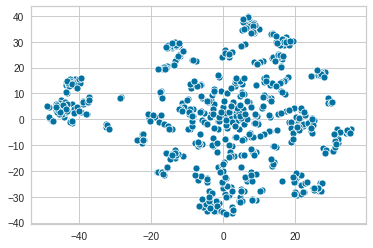

In [33]:
sns.scatterplot(x=tsne_count_label_vectors[:,0],
                y=tsne_count_label_vectors[:,1])

this looks a bit 'clustery' - so might work well with clustering

In [39]:
elbow_plot = KElbowVisualizer(KMeans(), k=(2,25))

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f849b6a5a58>,
                 k=None, metric=None, model=None, timings=True)

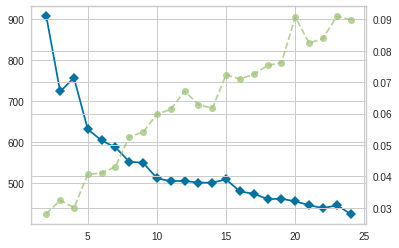

In [40]:
elbow_plot.fit(tsne_count_label_vectors)

would suggest 5 clusters is a good size as we stop getting larger gains around there

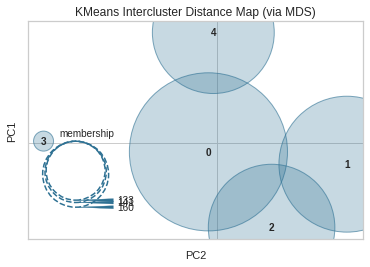

In [38]:
distance_plot = InterclusterDistance(KMeans(n_clusters=5))
distance_plot.fit(tsne_count_label_vectors).poof()

In [41]:
kmeans_mdl = KMeans(n_clusters = 5)

In [42]:
kmeans_labels = kmeans_mdl.fit_predict(tsne_count_label_vectors)

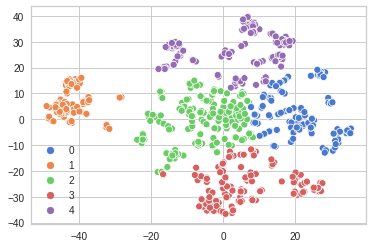

In [43]:
sns.scatterplot(x=tsne_count_label_vectors[:,0],
                y=tsne_count_label_vectors[:,1], 
                hue = kmeans_labels , 
                legend="full",
                palette =sns.color_palette("muted",
                                           n_colors=np.unique(kmeans_labels).size
                                          ))

lets have a look at the labels we have in each cluster we have picked out

In [44]:
labels_df["cluster"] = kmeans_labels

In [46]:
labels_df[labels_df.cluster == 0].index.to_list()

['. donations and legacies unrestricted restricted total total funds funds',
 '. income from charitable unrestricted restricted total total activities funds funds',
 '. mr l  reed',
 '.note funds funds',
 'accumulated losses',
 'amounts due from members',
 'amounts due from members included in  so debtors',
 'amounts due from members included in debtors loans and other debts due to members nod',
 'amounts due to members',
 'brought forward',
 'carried forward',
 'debtor from irish spv',
 'deposits received from reinsurers',
 'designated funds',
 'designated funds a',
 'designated income funds',
 'donations',
 'donations     legacies',
 'donations and legacies',
 'donations and legacies charitable activities investments wt mm',
 'donations and legacies charitable activities whd',
 'donations and legacies other trading activities income from investments income from charitable activities onan',
 'endownment fund',
 'equity',
 'equity shareholders funds',
 'equity shareholders funds oo .',

In [47]:
labels_df[labels_df.cluster == 1].index.to_list()

[' creditors amounts falling due after more than one year',
 '. . year',
 '. creditors amounts falling due within on year',
 'amounts failing due after more than one year',
 'amounts falling duc after more than onc year',
 'amounts falling due after more than one . year',
 'amounts falling due after more than one year',
 'amounts falling due in one year s',
 'amounts falling due within one year',
 'amounts falling due within one year   net current assets',
 'amounts falling due within one year   net current liabilities',
 'amounts falling due within one year  net current assets',
 'amounts falling due within one year .',
 'cash at bank 11942 20445 oo   creditors amounts falling due within one year',
 'creditors',
 'creditors   amounts falling due',
 'creditors  amounts falling due after more than one',
 'creditors  amounts falling due within one year',
 'creditors amaunts falling due  within one year',
 'creditors amount due within oneyear  s',
 'creditors amount falling due after more

that cluster appears to contain similar items, most of these contain the text 'falling due within one year'

In [48]:
labels_df[labels_df.cluster == 2].index.to_list()

[' i',
 '.',
 '. derivative assets exchange rate contracts crosscurrency swaps',
 '. derivative assets exchange rate contracts securitisation cross currency swaps',
 '. derivative assets interest rate contracts bermudan swaptions',
 '. derivative liabilities interest rate contracts bermudan swaptions q',
 '. fvtpl loans and advances to customers rollup mortgage portfolio',
 '. notes to consolidated financial statements as at and for the year ended march',
 '629100 594923 47671 89994 other trading activities shop income 629100 other income 47671 income from investments gift aid receivable from subsidiaries',
 'a',
 'abbeyfield properties limited  financial statements  march',
 'accountancy fee',
 'accruals',
 'accruals and deferred income',
 'accrued expenses',
 'accrued interest',
 'activities',
 'al',
 'allotted issued and fully paid',
 'amounts due in respect of profits',
 'annual programme  a',
 'aos',
 'approved by the board on',
 'arising out of direct insurance operations',
 'ari

In [50]:
labels_df[labels_df.cluster == 3].index.to_list()

['. total long term liabilities',
 '157301 783096 679940 total expenditure 620795 on investments',
 'and net assets',
 'assets',
 'current accounts',
 'current assets',
 'current assets inventories',
 'current assets.',
 'current liabilities',
 'current tax liabilities',
 'debtorsprepaymentsother current assets',
 'financial investments',
 'financial investments .',
 'fixed assets',
 'fixed assets     tangible assets note',
 'fixed assets  .',
 'fixed assets aircraft',
 'fixed assets fnavestments',
 'fixed assets intangible assets',
 'fixed assets intangible fixed assets .',
 'fixed assets investments',
 'fixed assets ntatigible assets  tangible assets',
 'gains on revaluations of fixed assets',
 'intangible asscts',
 'intangible assets',
 'intangible assets    tangible assets',
 'intangible assets .     tangible assets',
 'intangible assets tangible asscts luu',
 'intangible assets tangible assets bois',
 'intangible fixed assets',
 'investments',
 'investments  unquoted investments',

In [ ]:
Cluster 3 looks like it is pulling something to do with total assess or liabilites

In [51]:
labels_df[labels_df.cluster == 4].index.to_list()

['. profit and loss account',
 '.called up equity share capital',
 'adverse balance',
 'allotted called up and fully paid ordinary shares of  each',
 'allotted called. up.and unpaid',
 'amounts owed by group undertakings',
 'amounts owed from group undertakings',
 'amounts owed to group undertakings',
 'at cost',
 'balance at start of period',
 'balance sheet  ch',
 'balance sheet as at  march  none',
 'balance sheet as at january',
 'balance sheet as at st july  notes',
 'balance sheet total .  .',
 'bank',
 'bank and cash balances',
 'bank and cash in hand',
 'bank balance',
 'bank interest     .',
 'cailed up share capital',
 'called up equity share capital',
 'called up share capital',
 'called up share capital      profit and loss account . .',
 'called up share capital    profit and loss account',
 'called up share capital   profit and loss account',
 'called up share capital   retained earnings',
 'called up share capital  .',
 'called up share capital  ordinary share of',
 'cal